# Compress phase space via regrid/merge operations

A simple mechanism to reduce the size of phase space data is to merge identical particles while adding their weights. In practice, this doesn't tend to be that useful, because even in a large data set, there are quite few truly identical particles. What there **are** however, are many particles which are close together.

This tutorial demonstrates how to explot this fact by first regridding phase space data (which in effect 'nudges' particles which are close together in 7-D space into the same bin) followed by merging the phase space. This algorithm is based on work originally developed by LÃ©o Esnault for the [p2sat](https://github.com/lesnat/p2sat) code.

In [1]:
from pathlib import Path
import sys
sys.path.append('../')  # not necessary when the library is installed
from ParticlePhaseSpace import DataLoaders
from ParticlePhaseSpace import PhaseSpace
import numpy as np
from matplotlib import pyplot as plt

test_data_loc = Path(r'../tests/test_data/coll_PhaseSpace_xAng_0.00_yAng_0.00_angular_error_0.0.phsp').absolute()
ps_data = DataLoaders.Load_TopasData(test_data_loc)
PS = PhaseSpace(ps_data)

For this data set, the vast majority of the data is close to x=0, y=0, so I'm going to discard some of the scattered particles outside this range. (We will come back to this discarded data later).

In [2]:
keep_ind = np.logical_and(np.abs(PS.ps_data['x [mm]']) < 5, np.abs(PS.ps_data['y [mm]']) < 5)
keep_ind2 = np.logical_and(np.abs(PS.ps_data['px [MeV/c]']) < 1, np.abs(PS.ps_data['py [MeV/c]']) < 1)
keep_ind3 = np.logical_and(keep_ind2, keep_ind)
PS, PS_discard = PS.filter_by_boolean_index(keep_ind3, split=True)

data where boolean_index=True accounts for  89.6 % of the original data


Ok, so this operation removed about 10% of the input data.
First, let's try merging any identical particles:

In [3]:
# PS.merge(in_place=True)
# I'm not actually going to run this because it slows test execution too much - but trust me: it doesn't have any effect!

We can see that not only did this not remove many particles, it also took an quite a long time!

Let's try the same thing after performing a re-grid operation:

In [4]:
new_PS = PS.regrid(n_bins=100)

not regriding z as it is already single valued


not regriding time as it is already single valued


In [5]:
new_PS.merge(in_place=True)

merge operation removed  157174 particles. Original data had  279094
merge operation took  91.4 s


What we have done here is regridded the default quantitiues ['x', 'y', 'z', 'px', 'py', 'pz', 'time'] into 100 bins. The values for each bin are calculated based on the range of the input data. The resultant phase space is roughly 33% the size of the original data. Now, we can add back in the data we extracted previously:

In [6]:
new_PS = new_PS + PS_discard
PS = PS + PS_discard

The obvious question is: how have these operations effected the data set, so let's check:

## Particle Positions

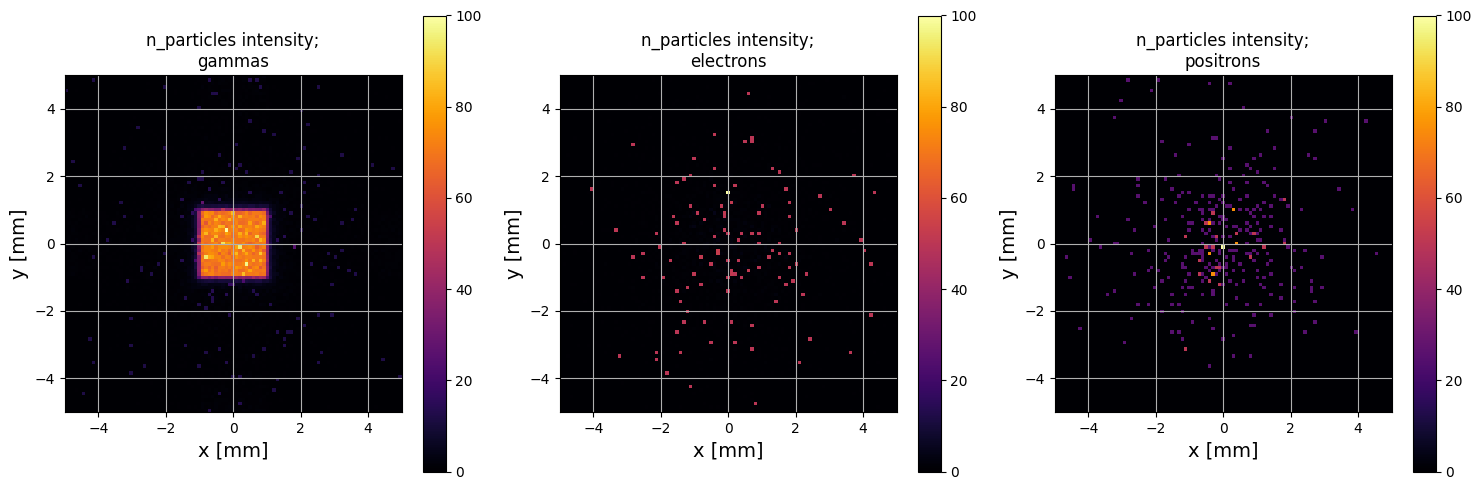

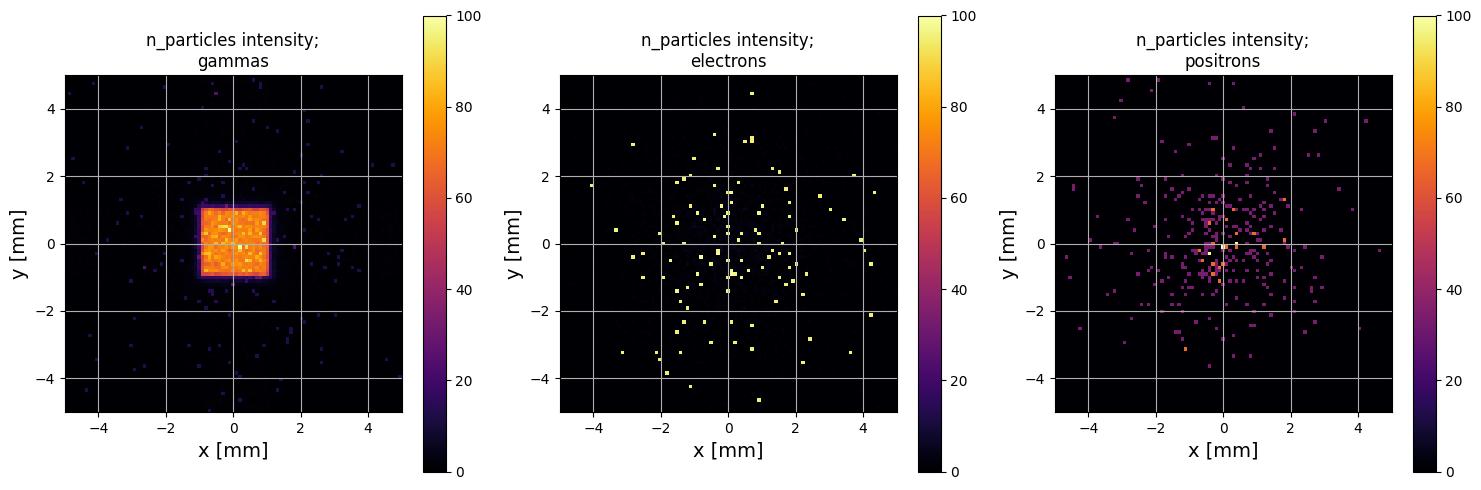

In [7]:
PS.plot.particle_positions_hist_2D(xlim=[-5,5], ylim=[-5,5])
new_PS.plot.particle_positions_hist_2D(xlim=[-5,5], ylim=[-5,5])

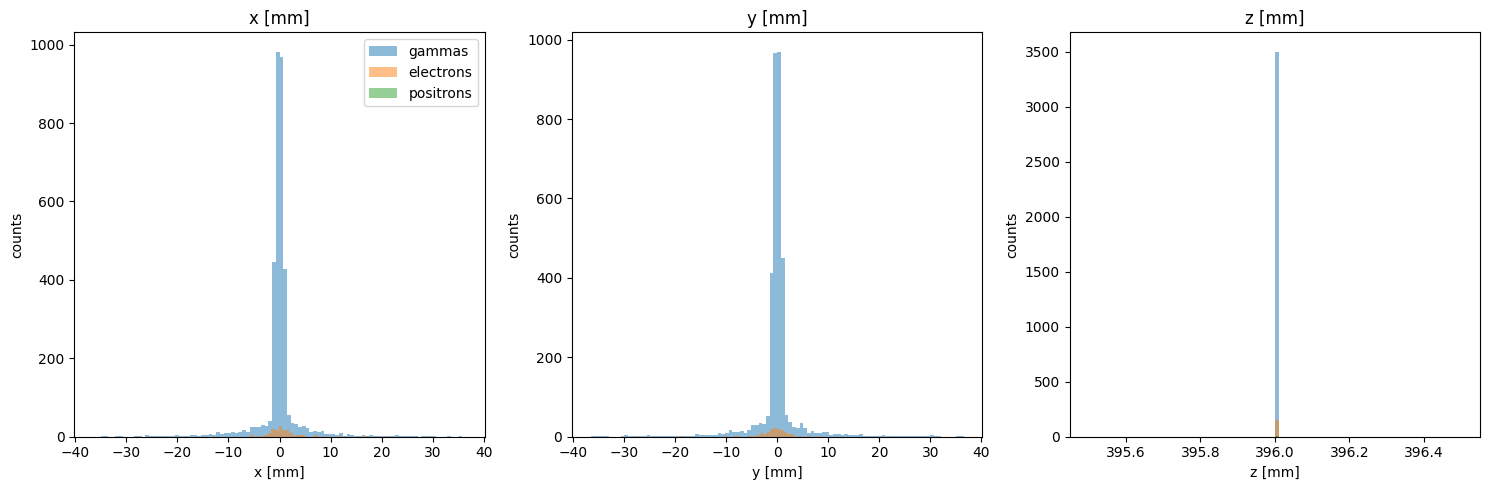

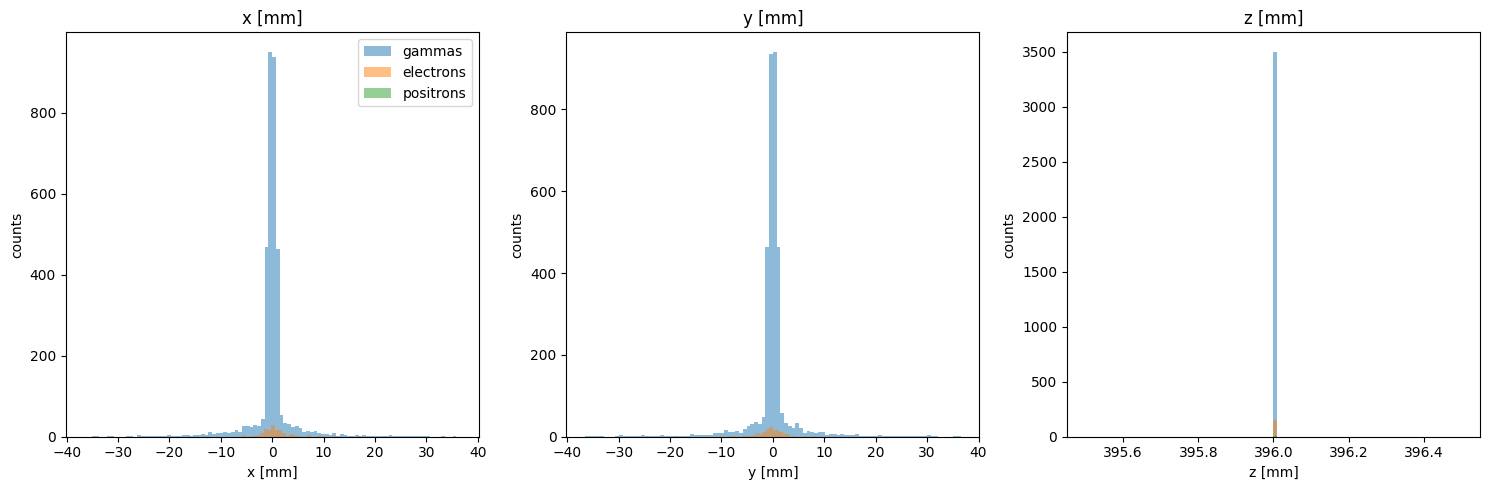

In [8]:
PS.plot.position_hist_1D()
new_PS.plot.position_hist_1D()

## Energy

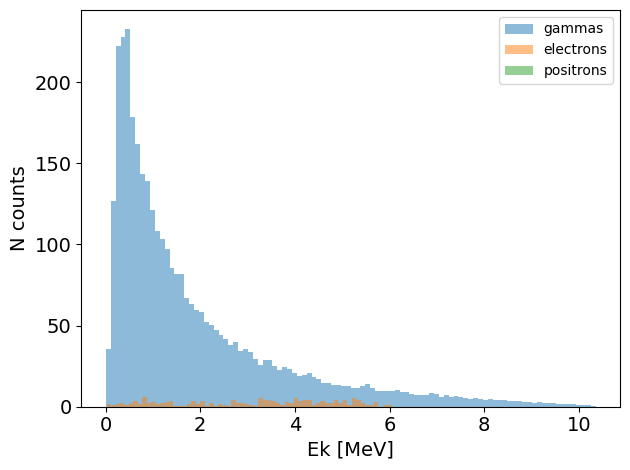

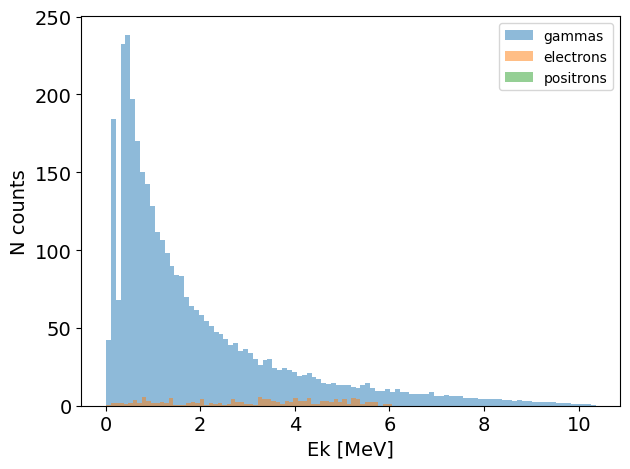

In [9]:
PS.plot.energy_hist_1D()
new_PS.plot.energy_hist_1D()

In [10]:
PS.print_energy_stats()
new_PS.print_energy_stats()

                 ENERGY STATS                  
total number of particles in phase space:  311489
number of unique particle species:  3
     308280 gammas
        mean energy:  1.91 MeV
        median energy:  1.20 MeV
        Energy spread IQR:  2.03 MeV
        min energy  0.01 MeV
        max energy  10.35 MeV
     2853 electrons
        mean energy:  3.16 MeV
        median energy:  3.39 MeV
        Energy spread IQR:  2.95 MeV
        min energy  0.02 MeV
        max energy  9.44 MeV
     356 positrons
        mean energy:  2.66 MeV
        median energy:  2.39 MeV
        Energy spread IQR:  2.39 MeV
        min energy  0.08 MeV
        max energy  8.46 MeV


                 ENERGY STATS                  
total number of particles in phase space:  154315
number of unique particle species:  3
     151106 gammas
        mean energy:  1.91 MeV
        median energy:  1.18 MeV
        Energy spread IQR:  2.09 MeV
        min energy  0.01 MeV
        max energy  10.35 MeV
     2853 electrons
        mean energy:  3.16 MeV
        median energy:  3.39 MeV
        Energy spread IQR:  2.95 MeV
        min energy  0.01 MeV
        max energy  9.44 MeV
     356 positrons
        mean energy:  2.66 MeV
        median energy:  2.38 MeV
        Energy spread IQR:  2.40 MeV
        min energy  0.08 MeV
        max energy  8.46 MeV


## Momentum

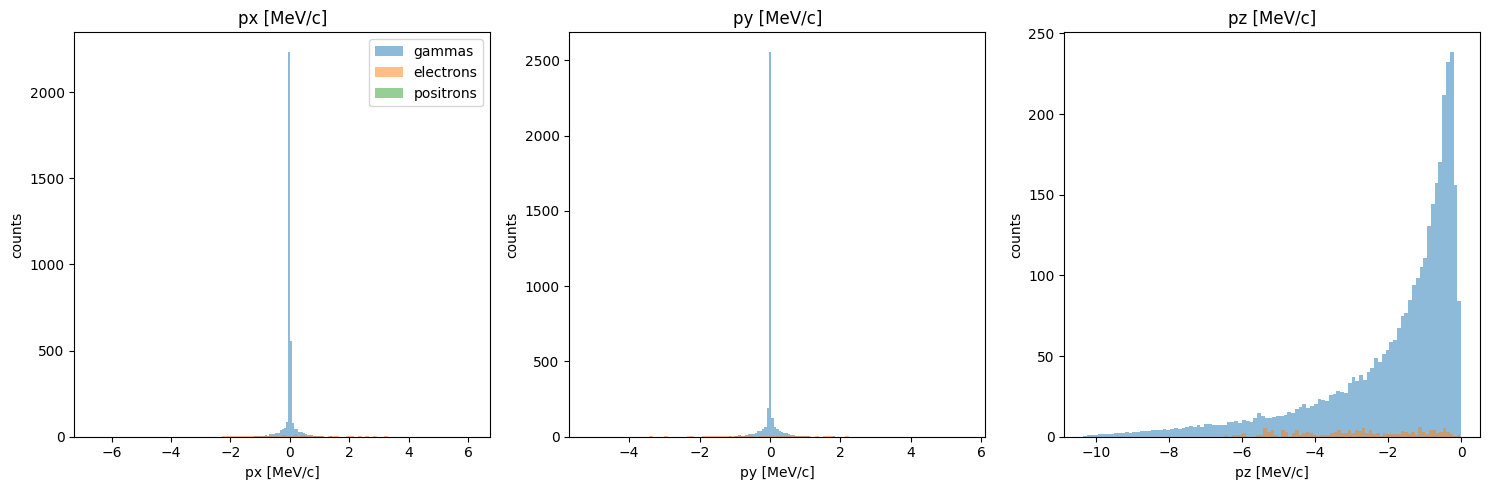

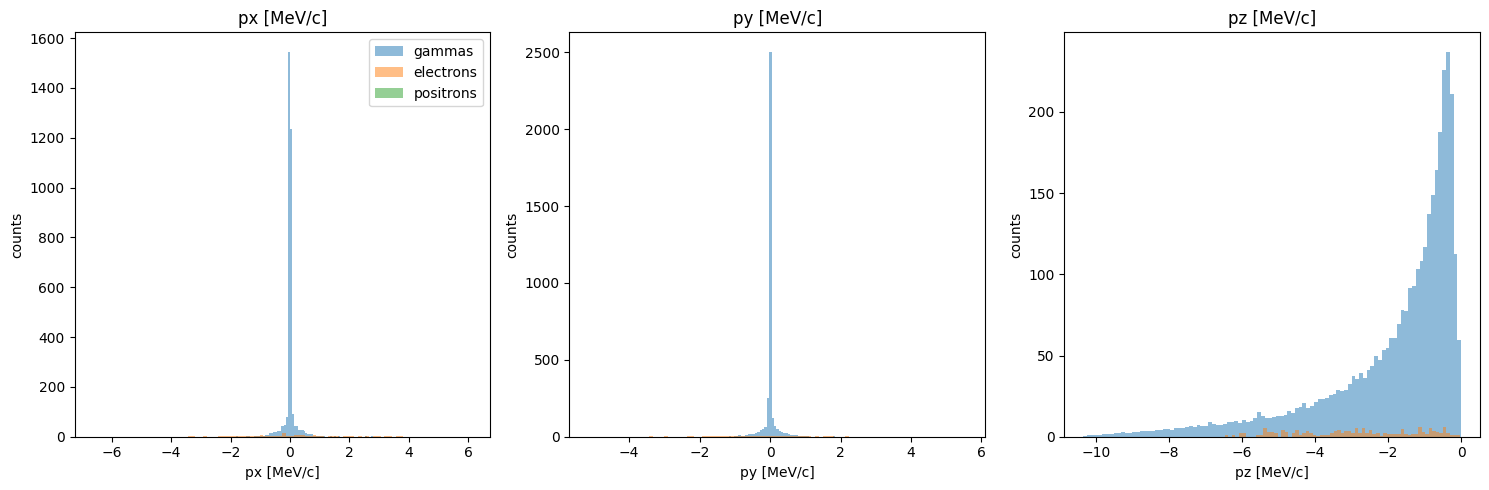

In [11]:
PS.plot.momentum_hist_1D()
new_PS.plot.momentum_hist_1D()

## Notes/ Conclusions

- If you want to not include some data in the regridding process, you need to do it before regridding as we did in this example. The regrid bins are always based on the min/max range of the input data, since not doing this could result in many particles being 'stacked' around the edge bins
- Grid/Merge operations can be a highly effective approach to reducing the total size of a phase space without losing too much information - however, as always, the extent to which this is appropriate is very much application specific.